# Plot ran_delay


## Task

**Read ```packets.json```**
    
**then plot `ran_delay' by reusing the code from [meas-visualization](https://github.com/gourav-prateek-sharma/meas-visualization).**


```packets.json``` contains journeys of about 10k packets with timestamps as each packet traverses through different layers in the 5G stack. 

The nested structure of the json objects within the json file is corresponding to the structure of mobile communication network protocal layers. Accordingly, the timestamps at different protocal layers are contained in different Json layers. 

The 1st nested layer json is corresponding to **rlc** and **ip**, then 2nd nested layer to **mac**, 3rd nested layer to **phy**

In [36]:
%%script structure_be_like_this↓
{
    {
        ......
        "ip.in_t": 1728415454.104354,
        "ip.out_t": 1728414859.949133,
        "rlc.in_t": 1728415454.104721,
        "rlc.out_t": 1728415454.128206,
        ......
        "rlc.attempts": [
            {
                ......
                "mac.in_t": 1728415454.117142,
                "mac.out_t": 1728415454.118214,
                ......
                "mac.attempts": [
                    {
                        "......
                        "phy.in_t": 1728415454.117146,
                        "phy.out_t": 1728415454.11813,
                        ......
                    }
                ]
            }

    },
    {
        .......
    },
}
......

Couldn't find program: 'structure_be_like_this↓'


Copy ```get_ran_delay()``` in ```decomp.py``` from [meas-visualization](https://github.com/gourav-prateek-sharma/meas-visualization)

In [37]:
from loguru import logger
import numpy as np
import json
import matplotlib.pyplot as plt
import os

def get_ran_delay(packet):
    if packet.get('ip.out_t')!=None and packet.get('ip.in_t')!=None:
        return (packet['ip.out_t']-packet['ip.in_t'])*1000
    else:
        logger.error(f"Packet {packet['id']} either ip.in_t or ip.out_t not present")
        return None

Copy ```plot_ccdf()``` in ```plot_helpers.py``` from [meas-visualization](https://github.com/gourav-prateek-sharma/meas-visualization)

$\text{CCDF}(x) = P(X>x) = 1 - F(x) = 1 - \text{CDF}(x)$

Complementary Cumulative Distribution Function (CCDF) = 1 -  Cumulative Distribution Function (CDF)

CCDF is used to measure tail probabilities (probabilities of extreme values)

In [38]:
def plot_ccdf(delays, label, figsize=(10, 6)):
    """
    Plots the Complementary Cumulative Distribution Function (CCDF) of the given delays.
    
    Parameters:
        delays (list or array-like): The delay values to plot.
        label (str): The label for the plot.
        figsize (tuple): The size of the figure (default is (10, 6)).
        
    Returns:
        fig, ax: The figure and axis objects of the plot.
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    # Sort the delay values and calculate the CCDF
    sorted_delays = np.sort(delays)
    ccdf = 1.0 - np.arange(1, len(sorted_delays) + 1) / len(sorted_delays)
    
    # Plot the CCDF
    ax.plot(sorted_delays, ccdf, linestyle='-', linewidth=4, label=label)
    
    # Set the y-axis to a logarithmic scale
    ax.set_yscale('log')
    
    # Label the axes
    ax.set_xlabel('Delay (ms)', fontsize=15)
    ax.set_ylabel('Probability', fontsize=15)
    ax.tick_params(axis='both', labelsize=16)

    
    # Add grid and legend
    ax.grid(True)
    ax.legend()
    
    return fig, ax

Copy from ```plots.ipynb``` from [meas-visualization](https://github.com/gourav-prateek-sharma/meas-visualization)

In [39]:
MEAS_LABEL = 's24'
PLOTS_DIR = './plots/'+MEAS_LABEL+'/'

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


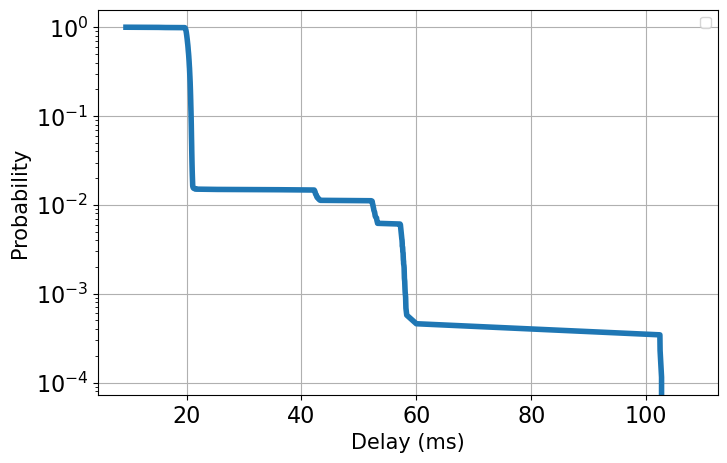

In [40]:
packets_path='./'+MEAS_LABEL+'/packets.json'
with open(packets_path, 'r') as file:
    packets = json.load(file)

ran_delays = np.array(list({packet['id']: get_ran_delay(packet) 
                                for packet in packets 
                                if get_ran_delay(packet) is not None}.values()))

# Ensure the PLOTS_DIR exists
if not os.path.exists(PLOTS_DIR):
    os.makedirs(PLOTS_DIR)

# skip first and last packets
SKIP_FIRST = 1200
SKIP_LAST = 100

fig, ax  = plot_ccdf(ran_delays[SKIP_FIRST:-SKIP_LAST], '_', figsize=(8, 5))
plt.savefig(f"{PLOTS_DIR}ran_delays_ccdf_plot.png", dpi=300, bbox_inches='tight')  # You can change the file format (e.g., .pdf)
plt.show()

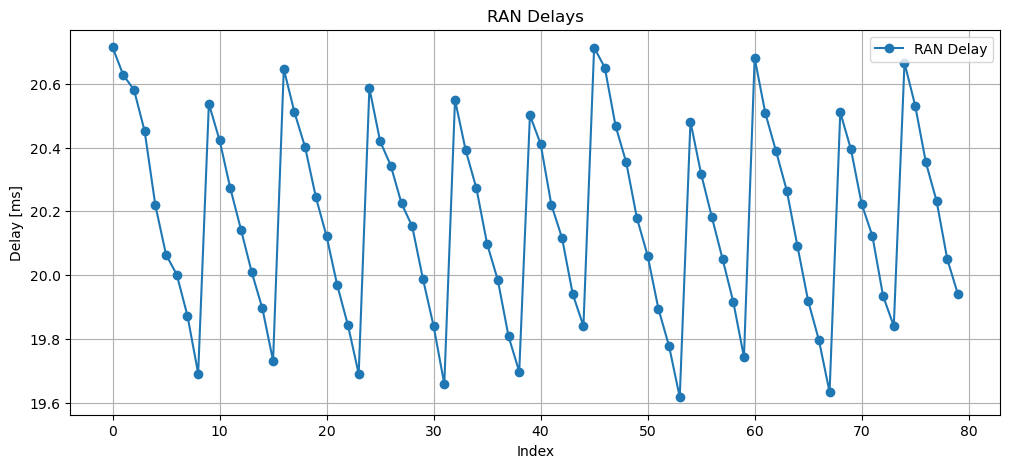

In [41]:
index_range = slice(1000, 1080)
SKIP_FIRST = 1000
SKIP_LAST = 100

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(ran_delays[index_range], marker='o', label='RAN Delay')
ax.set_xlabel('Index')
ax.set_ylabel('Delay [ms]')
ax.set_title('RAN Delays')

# Adding grid
ax.grid(True)

# Adding legend
ax.legend()

# Save the plot
plt.savefig(f"{PLOTS_DIR}ran_delays.png", dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

In [42]:
print(f"{len(ran_delays)} ip packets are included in {MEAS_LABEL+'/packets.json'}")
print(f"The first {np.argmax(ran_delays >= 0)} delay values are negative.")

id_to_indices={}
for index, d in enumerate(packets):
    id = d['id']
    if id not in id_to_indices:
        id_to_indices[id] = []
    id_to_indices[id].append(index) 

for id, indices in id_to_indices.items():
    if len(indices) > 1: 
        print(f" id='{id}': {len(indices)} packets")




10008 ip packets are included in s24/packets.json
The first 874 delay values are negative.


- Why are first and last packets skipped? why are there negative delays?
- Why do we use ```list({packet['id']: ...}.values())``` ? multiple packets have same id?